> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [NoshowAppointment]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 


#### Context

This is a dataset derived from appointments booking from an hospital.

#### Content

It has 110527 medical appointments data and its 14 associated variables . 


##### Attribute Information

PatientId: Identification of a patient

AppointmentID: Identification of each appointment

Gender: Male or Female.

AppointmentDay: The day of the actual appointment, when they have to visit the doctor.

ScheduledDay: The day someone called or registered the appointment, this is before appointment of course.

Age: How old is the patient.

Neighbourhood: Where the appointment takes place.

Scholarship: True of False .

Hipertension: True or False

Diabetes: True or False

Alcoholism: True or False

Handcap: True or False

SMS_received: 1 or more messages sent to the patient.

No-show: True or False.


### Question(s) for Analysis
 

1.Between males and females ,who are likely to attend a scheduled appointment.

2.what relation does age and gender have with apointment show up

In [3]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
# what I will be using in the project:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# loading in my dataset
df = pd.read_csv('./noshowappointments-kagglev2-may-2016.csv')

In [1]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.2


    100% |████████████████████████████████| 10.4MB 3.6MB/s eta 0:00:01   36% |███████████▌                    | 3.8MB 22.8MB/s eta 0:00:01    57% |██████████████████▌             | 6.0MB 24.7MB/s eta 0:00:01    98% |███████████████████████████████▋| 10.3MB 23.2MB/s eta 0:00:01
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
      Successfully uninstalled pandas-0.25.1


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [4]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
df.shape

(110527, 14)

In [6]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [8]:
#checking for missing values
df.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [9]:
#check for duplicated values
df.duplicated().sum()

0

In [10]:
# list the unique values for each column
for x in df.columns:
    print(x,'total unique values ' ,df[x].nunique(),"individual unique values ",df[x].unique(),'\n')

PatientId total unique values  62299 individual unique values  [2.98724998e+13 5.58997777e+14 4.26296230e+12 ... 7.26331493e+13
 9.96997666e+14 1.55766317e+13] 

AppointmentID total unique values  110527 individual unique values  [5642903 5642503 5642549 ... 5630692 5630323 5629448] 

Gender total unique values  2 individual unique values  ['F' 'M'] 

ScheduledDay total unique values  103549 individual unique values  ['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z'] 

AppointmentDay total unique values  27 individual unique values  ['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:0

In [11]:
# fixing  formatting errors for better readability
df.rename(columns = lambda x: x.strip().lower(), inplace=True)
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [12]:
#  rename no-show column
df = df.rename(columns = {'no-show':'no_show' })

In [13]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [14]:
# changing the no_show datatype from string to boolean
def noshow_to_boolean(status):
    '''Changing strings in the no show column to bools'''
    if status == 'No':
        return False
    else:
        return True
    
df["no_show"] = df["no_show"].apply(noshow_to_boolean)

## The data had no missing values and dublicate values,But had a negative age which is impossible meaning it was errant.Also we have the date datatype as object

In [15]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
#I am going to replace the negative value '-1' with the value 1
df[df['age'] < 0] = 1

df['age']

0         62
1         56
2         62
3          8
4         56
          ..
110522    56
110523    51
110524    21
110525    38
110526    54
Name: age, Length: 110527, dtype: int64

In [16]:
# list the unique values for each column
#Now let us check if the value has changes by checking the unique values again
for x in df.columns:
    print(x,'total unique values ' ,df[x].nunique(),"individual unique values ",df[x].unique(),'\n')

patientid total unique values  62299 individual unique values  [2.98724998e+13 5.58997777e+14 4.26296230e+12 ... 7.26331493e+13
 9.96997666e+14 1.55766317e+13] 

appointmentid total unique values  110527 individual unique values  [5642903 5642503 5642549 ... 5630692 5630323 5629448] 

gender total unique values  3 individual unique values  ['F' 'M' 1] 

scheduledday total unique values  103549 individual unique values  ['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z'] 

appointmentday total unique values  28 individual unique values  ['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00

In [19]:
# convert appoappointment day and scheduleday to date variables
df['appointmentday'].dtype
df['appointmentday']=pd.to_datetime(df['appointmentday'])
df['scheduledday']=pd.to_datetime(df['scheduledday'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null datetime64[ns, UTC]
appointmentday    110527 non-null datetime64[ns, UTC]
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: datetime64[ns, UTC](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


## As seen above the negative value in age was removed and now instead of 104 unique values we have 103 values in the age column.Also the ScheduledDay     and AppointmentDay  datatype has changed from object to datetime64

<a id='eda'></a>
## Exploratory Data Analysis



### Research Question 1 (1.Between males and females ,who are likely to attend a scheduled appointment.)

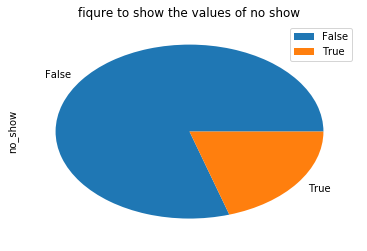

In [21]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
#First lets see percentage of turnup compared to failed ones
df["no_show"].value_counts().plot.pie()
plt.title('fiqure to show the values of no show')
plt.legend()


#### We can see that many people do turn up for an appointment rather than fail to show up.


In [1]:
df.head

NameError: name 'df' is not defined

### Research Question 2  (2.what relation does age and gender have with apointment show up.)

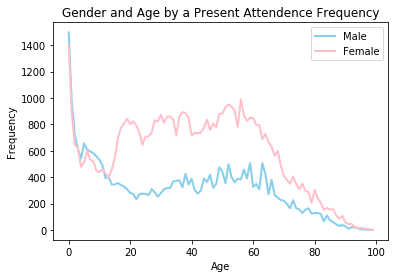

In [34]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
# analyzing the relationship of gender and age with patients who attended their appointent
range_df = pd.DataFrame()
range_df['age'] = range(100) # age limit of 100
male = range_df.age.apply(lambda x:len(df[(df.age == x) & (df.gender == 'M') & (df.no_show == False)]))
female = range_df.age.apply(lambda x:len(df[(df.age == x) & (df.gender == 'F') & (df.no_show == False)]))

# plotting the findings
plt.plot( range_df, male, color='skyblue', linewidth=2)
plt.plot( range_df, female, color='pink', linewidth=2)
plt.legend(['Male','Female'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Gender and Age by a Present Attendence Frequency');

### Generally ages between 20 and 60 attend more appointments than any other.
### Many females turn up for their appointments when compared to men.

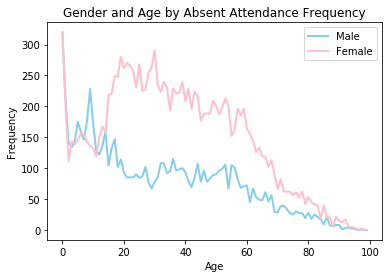

In [35]:
# analyzing the relationship of gender and age with patients who were absent to their appointment
range_df2 = pd.DataFrame()
range_df2['age'] = range(100) # age limit of 100
male2 = range_df.age.apply(lambda x:len(df[(df.age == x) & (df.gender == 'M') & (df.no_show == True)]))
female2 = range_df.age.apply(lambda x:len(df[(df.age == x) & (df.gender == 'F') & (df.no_show == True)]))

# plotting the findings
plt.plot( range_df2, male2, color='skyblue', linewidth=2)
plt.plot( range_df2, female2, color='pink', linewidth=2)
plt.legend(['Male','Female'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Gender and Age by Absent Attendance Frequency');

### Generally ages between 20 and 60 fail to attend more appointments than any other.
### Many females do not  turn up for their appointments when compared to men.

# limitation

In [30]:
# distribution of gender
df.groupby(df.gender).no_show.count()

gender
F    71840
M    38687
Name: no_show, dtype: int64

### As seen above comparing males to females will be biased since females are twice as many as men.This explain their high turn out in any comparison.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.
The age between 20 to 60 are the people that attend and equally fail to attend hospital appointments.

Judging by the high turn out of females in the data ,we are forced to assume that they they do care more about their health than the males.Although they at the same rate they miss to attend the appointments.Males never even bother to book.
> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 
The limitation as indicated in previous cells was that the number of males and females was unqual hence nalifying any possible reason to compare the two.

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])